In [1]:
# Copyright 2019 Ocean Exploration Trust & Ian Vaughn
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice,
#    this list of conditions and the following disclaimer.
#
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
#
# 3. Neither the name of the copyright holder nor the names of its contributors
#    may be used to endorse or promote products derived from this software
#    without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.


In [2]:
%matplotlib notebook

# First, import all our nice tools
from NGcore import NGdslog
from NGcore import NGtform
from NGcore import NGtime
import pandas as pd
import numpy as np
import pyproj
import math
import matplotlib.pyplot as plt

# Load our 
DATA_FILE='/data/NA094/usbl-2018/raw/NA094-validation.dat'
data = pd.read_csv(DATA_FILE)
# Everyone STILL has their own timestamps.
data['time'] = pd.to_datetime(data['unixtime'], unit='s')

# Shamelessly stolen from usbl-eval-NA097
d = {'start_time': ['2018-06-08T01:40:00Z','2018-06-08T01:53:30Z','2018-06-08T02:12:00Z','2018-06-08T02:43:30Z','2018-06-08T02:50:02Z','2018-06-08T03:13:45Z','2018-06-08T03:31:10Z','2018-06-08T03:46:35Z','2018-06-08T04:09:00Z','2018-06-08T04:42:00Z','2018-06-08T05:17:00Z'],
     'end_time': ['2018-06-08T01:53:00Z','2018-06-08T02:06:21Z','2018-06-08T02:25:10Z','2018-06-08T02:56:51Z','2018-06-08T03:13:00Z','2018-06-08T03:29:01Z','2018-06-08T03:45:42Z','2018-06-08T03:59:49Z','2018-06-08T04:24:00Z','2018-06-08T05:00:00Z','2018-06-08T05:33:00Z'],
     'name': ['est_opt_8m', 'est_opt_8m', 'small_hdg', 'small_pitch', 'smaller_hdg', 'near_zero_hdg', 'no_mru', 'hdg_sign', 'est_opt_100m', 'est_opt_500m', 'est_opt_1000m'],
    }
d['start_time'] = [NGtime.NGtimestamp.fromLog(x) for x in d['start_time']]
d['end_time'] = [NGtime.NGtimestamp.fromLog(x) for x in d['end_time']]
test_time_frame = pd.DataFrame(data=d)
# Everybody just HAS to have their own datetime format.  Yay.
test_time_frame['start_time'] = pd.to_datetime(test_time_frame['start_time'])
test_time_frame['end_time'] = pd.to_datetime(test_time_frame['end_time'])

# Analyzing the Results

## Step 1: Data import

The previous cell loads the validation dataset processed through nautilus `aggdata` portion of the USBL CalEst processing pipeline.  We also load the test bounds and descriptions used in the previous notebook, because consistency.

Now that all this is loaded, its ALWAYS a good idea to check that coordinate axes, etc, are all loaded correctly.  A quick plot of ship position usually helps-- note that matplotlib screwed up the axes on lat/lon as usual.

Still, these look good-- and consistent with our previous results, just as importantly!

<IPython.core.display.Javascript object>


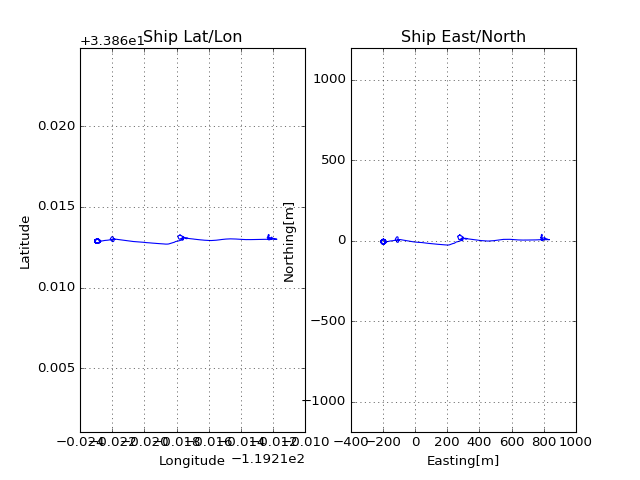

In [3]:
plt.subplot(121)
plt.plot(data['lon'], data['lat'])
plt.axis('equal')
plt.grid(True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ship Lat/Lon')

plt.subplot(122)
plt.plot(data['ship_x'], data['ship_y'])
plt.axis('equal')
plt.grid(True)
plt.xlabel('Easting[m]')
plt.ylabel('Northing[m]')
plt.title('Ship East/North')


<IPython.core.display.Javascript object>


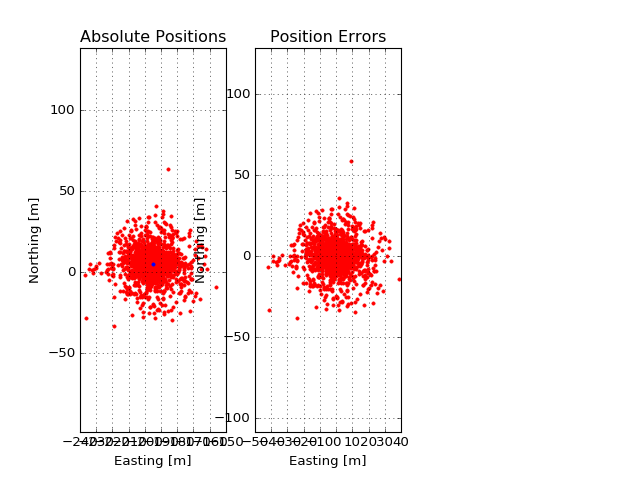

In [16]:
# Prepare some handy arrays

# So the USBL data is in Starboard-Forward-Down, which is a coordinate system used by NOBODY.
# At least its right-handed?
beacon_fsd = np.vstack((data['usbl_y'], data['usbl_x'], data['usbl_z']))
ship_ned = np.vstack((data['ship_y'], data['ship_x'], -data['ship_z']))
# This is the position of the USBL array relative to the ship's reference point.
# Based on the signs, and the forward/starboard/down thing, it should be:
# Aft of the reference point, port, and slightly above.  Remember that the reference point
# should be the SUBBOTTOM transduer, NOT the MRU, survey plate, or whatever.
beacon_to_ship_fsd = np.matrix([[-5.1130, -0.3460, -0.1130]]).transpose()
beacon_ned = np.zeros_like(ship_ned)
fsd_to_ned_R = [None]*beacon_fsd.shape[1]
# Go through and build all our rotation matrices
for i in range(0,len(fsd_to_ned_R)):
    coshdg = np.cos(np.radians(data['heading'][i]))
    sinhdg = np.sin(np.radians(data['heading'][i]))
    fsd_to_ned_R[i] = np.matrix([[coshdg, -sinhdg,0],[sinhdg, coshdg,0],[0,0,1]])
    
    # Of course we have to vstack and squeeze because numpy's array slicing sucks 
    # for matrices
    tmp = fsd_to_ned_R[i]*(np.vstack(beacon_fsd[:,i]) + beacon_to_ship_fsd) + np.vstack(ship_ned[:,i])
    beacon_ned[:,i] = np.squeeze(np.asarray(tmp))
    
    # Since we're here, go ahead and do the computation anyway

# We should compute a nominal beacon position
avg_ned = np.mean(beacon_ned,1)
error_ned = np.transpose(np.transpose(beacon_ned) - avg_ned)

# Plot, for luck
plt.figure()
plt.subplot(131)
plt.plot(beacon_ned[1,:], beacon_ned[0,:], 'r.')
plt.plot(avg_ned[1], avg_ned[0], 'b.')
#plt.plot(ship_ned[1,:], ship_ned[0,:], 'b.')
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
plt.grid(True)
plt.axis('Equal')
plt.title('Absolute Positions')

plt.subplot(132)
plt.plot(error_ned[1,:], error_ned[0,:], 'r.')
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
plt.grid(True)
plt.axis('Equal')
plt.title('Position Errors')

plt.show()

Average error, FWD:2.475+/-7.013, STBD:0.989+/-6.212, DWN: -0.000+/-6.576


<IPython.core.display.Javascript object>


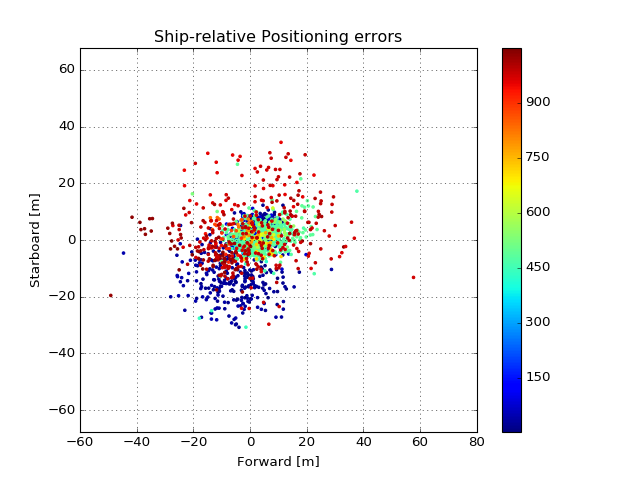

In [38]:
# Now for the secret sauce; Rotate BACK into the SHIP-RELATIVE Forward-starboard-down
error_fsd = np.zeros_like(error_ned)
for i in range(0,len(fsd_to_ned_R)):
    # Rotations are ORTHOGONAL matrices, so by the magic of linear algebra their inverse
    # is simply their transpose.  Convienent, yeh?
    tmp = fsd_to_ned_R[i].transpose()*np.vstack(error_ned[:,i])
    error_fsd[:,i] = np.squeeze(np.asarray(tmp))

xy_range = np.sqrt(np.square(beacon_fsd[0,:]) + np.square(beacon_fsd[1,:]))
xyz_range = np.sqrt(np.square(xy_range) + np.square(beacon_fsd[2,:]))

avg_fsd = np.mean(error_fsd,1)
std_fsd = np.std(error_fsd,1)
print('Average error, FWD:%.3f+/-%.3f, STBD:%.3f+/-%.3f, DWN: %.3f+/-%.3f'
     % (avg_fsd[0], std_fsd[0], avg_fsd[1], std_fsd[1], avg_fsd[2], std_fsd[2]))

plt.figure()
#plt.plot(error_fsd[0,:], error_fsd[1,:], 'r.')
plt.scatter(error_fsd[0,:], error_fsd[1,:], marker='.', c=xy_range, edgecolors='face')
#plt.plot(avg_fsd[0], avg_fsd[1], 'k.')
plt.xlabel('Forward [m]')
plt.ylabel('Starboard [m]')
plt.title('Ship-relative Positioning errors')
plt.grid(True)
plt.axis('equal')
plt.colorbar()
plt.show()
    

How do we know this worked?  If we change the sign of the offset, we get the following output from the previous cell: 

```
Average error, FWD:11.276+/-7.995, STBD:1.584+/-6.611, DWN: 0.000+/-6.576
```

Compare that to the error with the correct offsets: 

```
FWD:2.475+/-7.013, STBD:0.989+/-6.212, DWN: -0.000+/-6.576
```


<IPython.core.display.Javascript object>


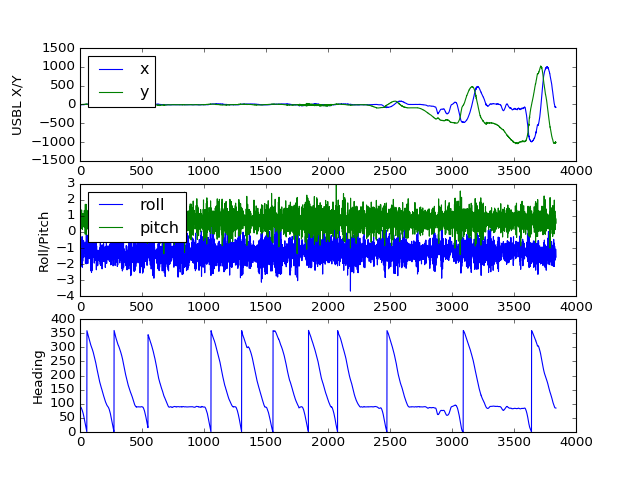

In [39]:
plt.figure()
plt.subplot(311)
plt.plot(data['usbl_x'], label='x')
plt.plot(data['usbl_y'], label='y')
plt.legend(loc='upper left')
plt.ylabel('USBL X/Y')

plt.subplot(312)
plt.plot(data['roll'], label='roll')
plt.plot(data['pitch'], label='pitch')
plt.legend(loc='upper left')
plt.ylabel('Roll/Pitch')


plt.subplot(313)
plt.plot(data['heading'])
plt.ylabel('Heading')

plt.show()

<IPython.core.display.Javascript object>


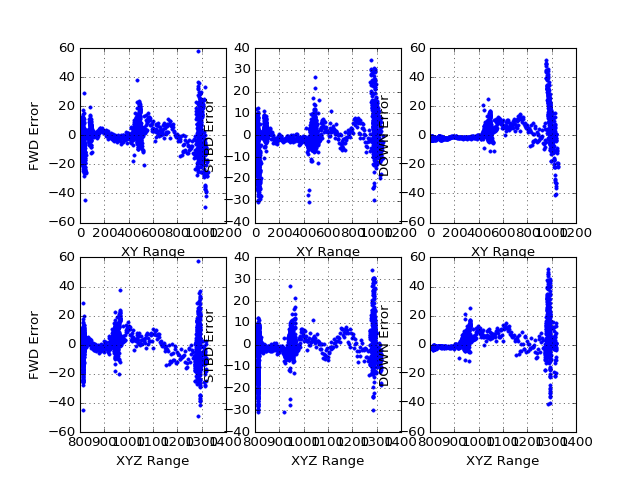

In [23]:
plt.figure()

plt.subplot(231)
plt.plot(xy_range, error_fsd[0,:], '.')
plt.xlabel('XY Range')
plt.ylabel('FWD Error')
plt.grid(True)

plt.subplot(232)
plt.plot(xy_range, error_fsd[1,:], '.')
plt.xlabel('XY Range')
plt.ylabel('STBD Error')
plt.grid(True)

plt.subplot(233)
plt.plot(xy_range, error_fsd[2,:], '.')
plt.xlabel('XY Range')
plt.ylabel('DOWN Error')
plt.grid(True)

plt.subplot(234)
plt.plot(xyz_range, error_fsd[0,:], '.')
plt.xlabel('XYZ Range')
plt.ylabel('FWD Error')
plt.grid(True)

plt.subplot(235)
plt.plot(xyz_range, error_fsd[1,:], '.')
plt.xlabel('XYZ Range')
plt.ylabel('STBD Error')
plt.grid(True)

plt.subplot(236)
plt.plot(xyz_range, error_fsd[2,:], '.')
plt.xlabel('XYZ Range')
plt.ylabel('DOWN Error')
plt.grid(True)

plt.show()

<IPython.core.display.Javascript object>


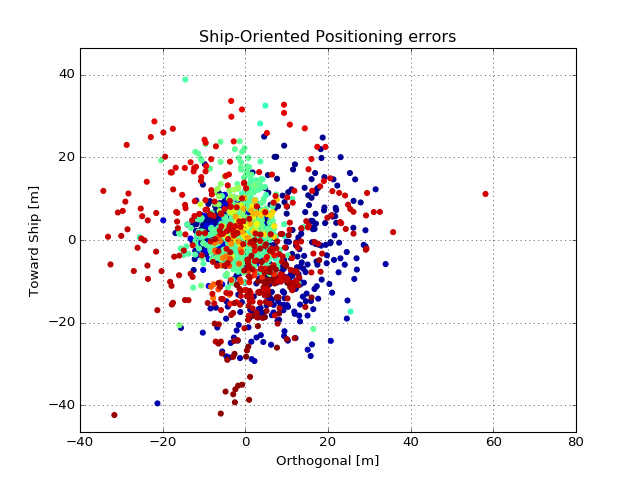

<IPython.core.display.Javascript object>


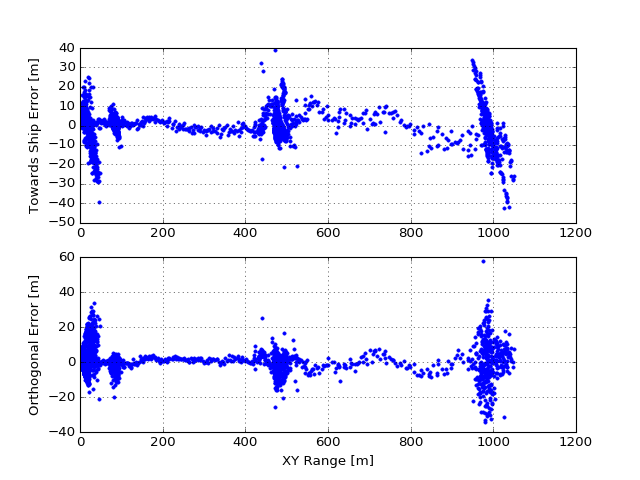

In [37]:
# Yeah, ok that makes literally no sense.
# Let's consider now a different parameterization.  Let's look at error in 
# beacon position towards the ship or away from the ship, as well as the residual component
# This is equivalent to a rotation that puts the +Y axis towards the ship and +X +90deg in heading
# from that bearing.
error_shipdir = np.zeros((2, error_ned.shape[1]))
for i in range(0, error_shipdir.shape[1]):
    
    # First, construct an orthonormal basis pointing from the beacon to the ship
    tmp = ship_ned[0:2,i] - avg_ned[0:2]
    unitvec = tmp/np.linalg.norm(tmp)
    ortho_unitvec = np.array([unitvec[1], -unitvec[0]])
    
    # Use that basis to rotate the error
    error_shipdir[0,i] = np.dot(unitvec, error_ned[0:2,i])
    error_shipdir[1,i] = np.dot(ortho_unitvec, error_ned[0:2,i])
    
plt.figure()
plt.scatter(error_shipdir[1,:], error_shipdir[0,:], c=xy_range, edgecolors='face')
plt.xlabel('Orthogonal [m]')
plt.ylabel('Toward Ship [m]')
plt.title('Ship-Oriented Positioning errors')
plt.grid(True)
plt.axis('equal')

plt.figure()

plt.subplot(211)
plt.plot(xy_range, error_shipdir[0,:], '.')
plt.ylabel('Towards Ship Error [m]')
plt.grid(True)
plt.subplot(212)
plt.plot(xy_range, error_shipdir[1,:], '.')
plt.ylabel('Orthogonal Error [m]')
plt.xlabel('XY Range [m]')
plt.grid(True)

plt.show()    